In [6]:
# Importamos librerías
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pysentimiento import create_analyzer
from wordcloud import WordCloud
from unidecode import unidecode
from nltk.corpus import stopwords
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('seaborn-darkgrid')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# Cargamos el dataset
df_raw = pd.read_csv("../data/raw/full_info.csv")

In [9]:
# Copiamos el df para hacer transformaciones
df_interim = df_raw.copy()

In [10]:
# Pasamos postdate a tipo fecha
df_interim['PostDate'] = df_interim['PostDate'].astype('datetime64')
# Pasamos tweets a tipo string
df_interim['Tweet'] = df_interim['Tweet'].astype('string')

In [11]:
# Nos quedamos con las variables relevantes para nuestro análisis
df_interim = df_interim[['TweetID', 'User', 'Handle', 'PostDate',
                         'Tweet', 'ReplyCount', 'RetweetCount', 'LikeCount', 'PersonasStanza']]

In [12]:
# Creamos columnas con las fechas por separado
df_interim['year'] = df_interim['PostDate'].dt.year
df_interim['month'] = df_interim['PostDate'].dt.month
df_interim['date'] = df_interim.apply(
    lambda x: x['PostDate'].strftime("%Y-%m-%d"), axis=1)

In [13]:
# Eliminamos los valores nulos
df_interim = df_interim.dropna(axis=0)

In [14]:
# Copiamos el dataframe para hacer EDA
df = df_interim.copy()

## Data pre-processing

In [15]:
# Limpiamos el texto para poder hacer NLP
# Pasamos a minúsculas
df['tweets_clean'] = df['Tweet'].str.lower()

# Eliminamos URLs:
def https(text):
    return re.sub(r"http\S+", "", text)

df['tweets_clean'] = df['tweets_clean'].apply(https)

url_pat = 'https://t.co/[A-Za-z\d]+|&amp;'
df['tweets_clean'] = df['tweets_clean'].str.replace(url_pat, '', regex=True)

url_pat_2 = 'https://[A-Za-z\d]+|&amp;'
df['tweets_clean'] = df['tweets_clean'].str.replace(url_pat_2, '', regex=True)

url_pat_3 = 'http://[A-Za-z\d]+|&amp;'
df['tweets_clean'] = df['tweets_clean'].str.replace(url_pat_3, '', regex=True)

# Aplicamos unidecode
df['tweets_clean'] = df['tweets_clean'].apply(unidecode)

# Eliminamos números
df['tweets_clean'] = df['tweets_clean'].str.replace(r'[\d]+', '', regex = True)

# Eliminamos caracteres especiales:
df['tweets_clean'] = df['tweets_clean'].str.replace(
    r'''[!.,():\-%$/'"''&;'\n\n'#|_']''', '', regex=True)

# Eliminamos palabras irrelevantes
df['tweets_clean'] = df['tweets_clean'].str.replace('ladiariafindesemana', '')
df['tweets_clean'] = df['tweets_clean'].str.replace('larepublica', '')
df['tweets_clean'] = df['tweets_clean'].str.replace('portada hoy', '')
df['tweets_clean'] = df['tweets_clean'].str.replace('exclusiva suscriptores', '')
df['tweets_clean'] = df['tweets_clean'].str.replace('suscriptores member', '')
df['tweets_clean'] = df['tweets_clean'].str.replace('nota exclusiva', '')
df['tweets_clean'] = df['tweets_clean'].str.replace('web diario', '')

In [16]:
# Definimos función para eliminar stopwords
def clean_stopwords(text: str, stop_dict: dict) -> str:
    if text is not None:
        words = text.split()
        words_clean = []
        for word in words:
            if word not in stop_dict:
                words_clean.append(word)
        result = ' '.join(words_clean)
    else:
        result = None
    return result

In [17]:
# Eliminamos los stopwords de la columna tweets_clean
stop_dict = stopwords.words('spanish')
df['tweets_clean'] = df['tweets_clean'].apply(
    lambda x: clean_stopwords(x, stop_dict=stop_dict))

In [131]:
#Lematización

#df['lema'] = np.nan

#for i in range(0, len(df)):
#    text = df['tweets_clean'].iloc[i]
#    df['lema'][i] = str(text)

In [19]:
# Convertimos 'user' en dummy
df['User_original'] = df['User']
df = pd.get_dummies(df, columns=['User'], drop_first=True)

In [22]:
# Generamos las variables independientes para nuestro modelo
# Creamos dummies para cada uno de los candidatos
df['mujica'] = np.where(
    df['PersonasStanza'].str.contains('Mujica', case=False), 1, 0)
df['lacalle'] = np.where(
    df['PersonasStanza'].str.contains('Lacalle P', case=False), 1, 0)
df['vazquez'] = np.where(
    df['PersonasStanza'].str.contains('Vázquez', case=False), 1, 0)
df['martinez'] = np.where(
    df['PersonasStanza'].str.contains('Daniel M', case=False), 1, 0)
df['larranaga'] = np.where(
    df['PersonasStanza'].str.contains('Larrañaga', case=False), 1, 0)
df['sendic'] = np.where(
    df['PersonasStanza'].str.contains('Sendic', case=False), 1, 0)
df['sartori'] = np.where(
    df['PersonasStanza'].str.contains('Sartori', case=False), 1, 0)
df['manini'] = np.where(
    df['PersonasStanza'].str.contains('Manini', case=False), 1, 0)
df['talvi'] = np.where(
    df['PersonasStanza'].str.contains('Talvi', case=False), 1, 0)

In [23]:
df['suma'] = df['mujica'] + df['lacalle'] + df['vazquez'] + df['martinez'] + df['larranaga'] + df['sendic'] + df['sartori'] + df['manini'] + df['talvi']

In [24]:
# Filtramos el dataframe para quedarnos solo con aquellas observaciones que mencionan a alguno de los candidatos
df_filtered = df[df['suma'] >= 1]
df_filtered = df_filtered.reset_index(drop=True)

In [25]:
# Nos guardamos esto para pruebas
df_filtered.to_csv('../data/processed/df_limpia.csv')

## Análisis NLP

Para nuestro análisis usamos la librería [*pysentimiento*](https://github.com/pysentimiento/pysentimiento/).

In [ ]:
#Si tuviéramos que correr el análisis de sentimiento de nuevo,
# acá podemos levantar directamente la df_limpia y no tener que correr todo el pre-procesamiento de nuevo

In [26]:
analyzer = create_analyzer(task="sentiment", lang="es")

Downloading: 100%|██████████| 925/925 [00:00<00:00, 248kB/s]
Downloading: 100%|██████████| 415M/415M [00:08<00:00, 49.4MB/s] 
Downloading: 100%|██████████| 150/150 [00:00<00:00, 39.3kB/s]
Downloading: 100%|██████████| 838k/838k [00:00<00:00, 2.25MB/s]


In [28]:
# Generamos una nueva columna con el sentimiento derivado de pysentimiento
df_filtered['sentimiento'] = np.nan

for i in range(0, len(df_filtered)):
    a = analyzer.predict(df_filtered['tweets_clean'].iloc[i])
    df_filtered['sentimiento'][i] = re.findall(r'{([A-Za-z]+)', str(a))[0]

/tmp/ipykernel_2822/563555667.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentimiento'][i] = re.findall(r'{([A-Za-z]+)', str(a))[0]


KeyboardInterrupt: 

In [43]:
# Guardamos en csv la base con la columna 'sentimiento'
df_filtered.to_csv('../data/processed/df_sentimiento_2.csv', index = False)

In [ ]:
df_filtered.to_csv('../data/processed/df_sentimiento_2_indextrue.csv')

In [49]:
df_filtered = pd.read_csv('../data/processed/df_sentimiento_2.csv')

In [51]:
# Categorizamos 'sentimiento'
df_filtered['sentimiento'] = df_filtered['sentimiento'].astype('category')
df_filtered['sentimiento'] = df_filtered['sentimiento'].cat.codes

In [52]:
# Definimos para generar labels para la variable 'sentimiento'
def labels(sentimiento):
    if sentimiento == 0:
        return 'negativo'
    if sentimiento == 1:
        return 'neutral'
    if sentimiento == 2:
        return 'positivo'

In [53]:
# Aplicamos la función creada
df_filtered['sentimiento_lab'] = df_filtered.apply(
    lambda x: labels(x['sentimiento']), axis=1)

In [40]:
df_filtered['sentimiento'].value_counts()
# 1 NEUTRAL
# 0 NEGATIVO
# 2 POSITIVO

1    33249
0     8710
2      427
Name: sentimiento, dtype: int64

Intento de mejorar el modelo

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
features = vectorizer.fit_transform(df_filtered['tweets_clean'])

count_vect_df = pd.DataFrame(features.todense(), columns=vectorizer.get_feature_names())
prueba2 = pd.concat([df_filtered, count_vect_df], axis=1)

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
lista = list(count_vect_df.columns)

In [55]:
#from sklearn.feature_extraction.text import CountVectorizer
#matriz_vectorizada = CountVectorizer().fit_transform(df_filtered['tweets_clean'])

In [ ]:
#X = vect.fit_transform(docs) 
#count_vect_df = pd.DataFrame(matriz_vectorizada.todense(), columns=vect.get_feature_names())

## Modelos:
</br> Vamos a probar dos modelos, árbol de decisión y regresión logística.

In [157]:
type(lista)

list

In [33]:
X2 = prueba2[['User_BÚSQUEDA', 'User_EL PAÍS', 'User_El Observador', 'User_La República', 'User_la diaria',
                 'mujica', 'lacalle', 'vazquez', 'martinez', 'larranaga', 'sendic', 'sartori', 'manini', 'talvi'] + lista]

In [166]:
#prueba2[lista]

In [34]:
#list(df_filtered.columns)

In [37]:
# Dividimos el df
#X = df_filtered[['User_BÚSQUEDA', 'User_EL PAÍS', 'User_El Observador', 'User_La República', 'User_la diaria',
#                 'mujica', 'lacalle', 'vazquez', 'martinez', 'larranaga', 'sendic', 'sartori', 'manini', 'talvi']]
X = X2
y = df_filtered['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=25)

ValueError: Input contains NaN

**Modelo 1:** Decision tree

In [140]:
# Inicializamos modelo
model_1 = DecisionTreeClassifier(random_state=25, class_weight = {0:1,1:1,2:50}, max_depth=2)

In [141]:
# Ajustamos modelo
model_1.fit(X_train, y_train)


DecisionTreeClassifier(class_weight={0: 1, 1: 1, 2: 50}, max_depth=2,
                       random_state=25)

In [142]:
# Predecimos
y_pred_1 = model_1.predict(X_test)

In [143]:
# Accuracy score
model_1.score(X_test, y_test)
# El modelo alcanzó una accuracy de 68,3%

0.6836518046709129

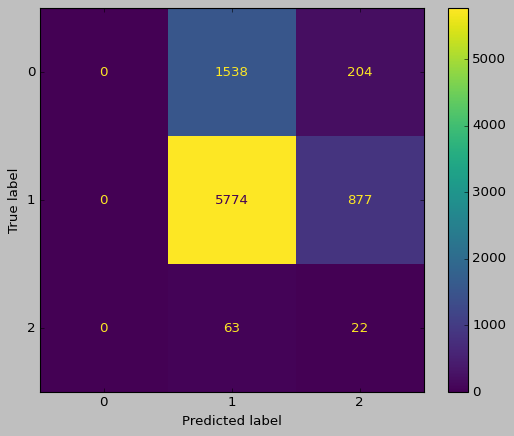

In [144]:
cm_1 = confusion_matrix(y_test, y_pred_1, labels=model_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1,
                              display_labels=model_1.classes_)
disp.plot()
plt.show()

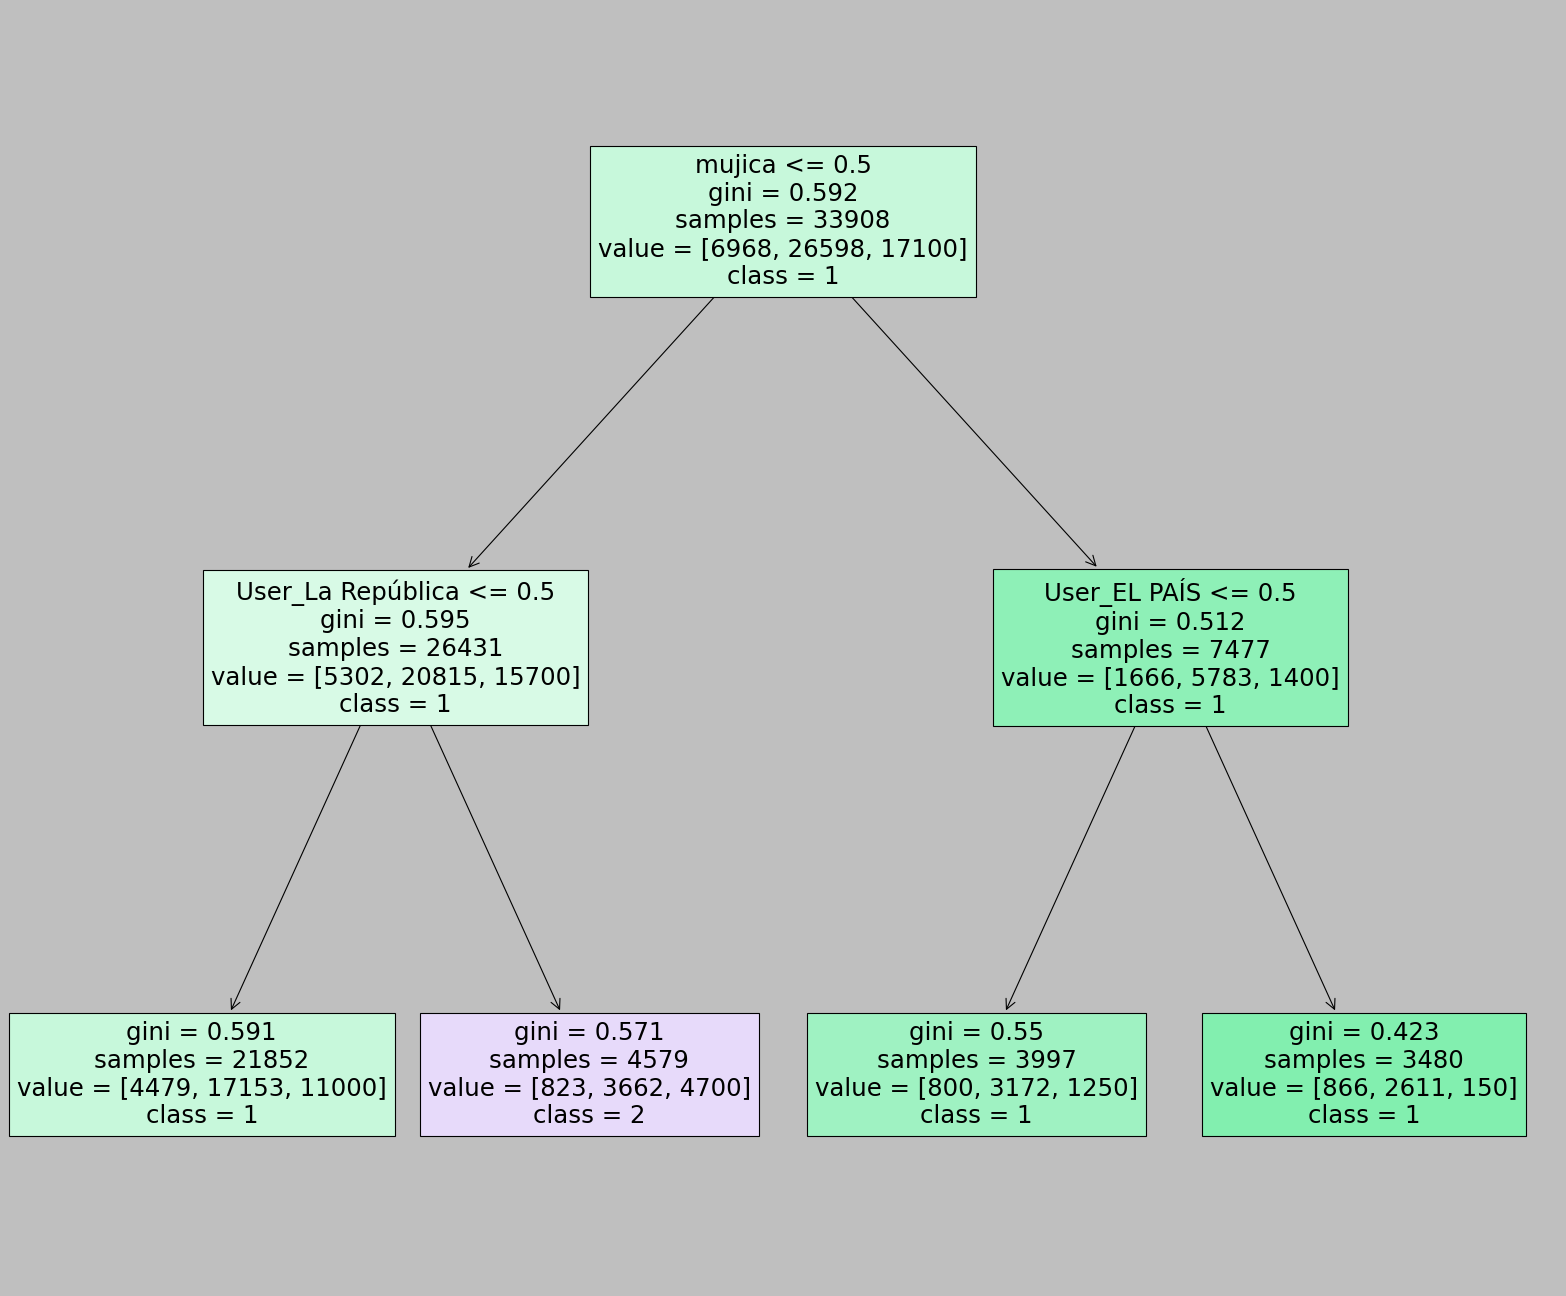

In [147]:
# Imprimimos el árbol para entender las reglas de decisión
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_1,
feature_names=X.columns,
class_names=['0','1','2'],
filled=True)

In [145]:
print(classification_report(y_test, y_pred_1))
# Si bien nuestro modelo alcanzó una accuracy alta, está haciendo overfitting
# Falla en predecir correctamente los 0 y 2
# Probablemente se deba a la ambigüedad de nuestras variables dependientes, por ejemplo: un medio
# puede hablar de la misma persona de manera positiva o negativa en diferentes publicaciones

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1742
           1       0.78      0.87      0.82      6651
           2       0.02      0.26      0.04        85

    accuracy                           0.68      8478
   macro avg       0.27      0.38      0.29      8478
weighted avg       0.61      0.68      0.65      8478



/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Modelo 2: Regresión logística

In [38]:
# Inicializamos modelo
model_2 = LogisticRegression(max_iter=200, random_state=25)

In [39]:
# Ajustamos modelo
model_2.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=25)

In [40]:
# Predecimos
y_pred_2 = model_2.predict(X_test)

In [41]:
# Accuracy score
accuracy_score(y_test, y_pred_2)
# El modelo alcanzó una accuracy de 78,45%


0.7845010615711253

In [50]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1742
           1       0.78      1.00      0.88      6651
           2       0.00      0.00      0.00        85

    accuracy                           0.78      8478
   macro avg       0.26      0.33      0.29      8478
weighted avg       0.62      0.78      0.69      8478



/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [146]:
# Guardamos el modelo 1
import pickle
filename = '../models/model_1.pkl'
pickle.dump(model_1, open(filename, 'wb'))

In [101]:
# Cargamos modelo 1
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
# Generamos listas y función de predicción para agregar en Streamlit:
users = {'Búsqueda': 0, 'El País': 1, 'El Observador': 2,
         'La República': 3, 'La diaria': 4, 'Brecha': 5}
personas = ['mujica', 'lacalle', 'vazquez', 'martinez',
            'larranaga', 'sendic', 'sartori', 'manini', 'talvi']
persons = {nombre: idx+5 for idx, nombre in enumerate(personas)}


def predic(user, person):
    x_aux = np.zeros((1, 14))
    # print(x_aux)
    if user != 'Brecha':
        x_aux[0][users[user]] = 1
    x_aux[0][persons[person]] = 1
    #print(user, person)
    # print(x_aux)
    output = model_1.predict(x_aux)
    if output[0] == 0:
        return 'negativo'
    if output[0] == 1:
        return 'neutral'
    if output[0] == 2:
        return 'positivo'
    return None

In [ ]:
# Probamos la función
predic('El País', 'mujica')

In [108]:
lemmas

['ser',
 'uno',
 'texto',
 'que',
 'pedir',
 'a',
 'grito',
 'que',
 'él',
 'procesen',
 '.',
 'por',
 'ese',
 'yo',
 'canto',
 ',',
 'tú',
 'canta',
 ',',
 'él',
 'cantar',
 ',',
 'yo',
 'cantar',
 ',',
 'cantái',
 ',',
 'cantar']